<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>


**CONTESTO:**

Il set di dati CalCOFI rappresenta la serie temporale più lunga (1949-oggi) e più completa (più di 50.000 stazioni di campionamento) di dati oceanografici e larvali di pesci nel mondo. Include dati sull'abbondanza delle larve di oltre 250 specie di pesci; dati sulla frequenza della lunghezza larvale e dati sull'abbondanza di uova su specie commerciali chiave; e dati oceanografici e planctonici. I dati fisici, chimici e biologici raccolti a intervalli regolari di tempo e spazio sono diventati rapidamente preziosi per documentare i cicli climatici nella Corrente della California e una serie di risposte biologiche ad essi.


**OBIETTIVO:** 

Rispondere alle seguenti domande analizzando e creando uno o più modelli predittivi, utilizzando i vari algoritmi visti a lezione (albero decisionale regressore, regressione lineare etc..) a partire dai dati a disposizione e su un subset delle prime 500 righe:

-------------------------------------------------------------------------
- Esiste una relazione tra salinità dell'acqua e temperatura dell'acqua? Giustifica la tua risposta con l'output del tuo modello predittivo
- Puoi prevedere la temperatura dell'acqua in base alla salinità?


**DATI A DISPOSIZIONE:**

Da questo link puoi scaricare i dati necessari:

https://www.kaggle.com/datasets/sohier/calcofi




# Oceanographic analysis

## Exploratory data analysis

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

plt.rcParams['figure.figsize'] = (10.0, 8) # set default size of plots
pd.set_option('display.max_rows', 2536)
pd.set_option('display.max_columns', 100)

### Cleaning data

In [281]:
# Loading the dataframes
#cast = pd.read_csv('./cast.csv', low_memory=False, nrows=500)
bottle = pd.read_csv('./bottle.csv', low_memory=False)

# Removing null columns
bottle_null_percentages = bottle.isnull().mean()
bottle_null_cols = bottle_null_percentages[bottle_null_percentages > 0.6].index.tolist()
#cast_null_percentages = cast.isnull().mean()
#cast_null_cols = cast_null_percentages[cast_null_percentages > 0.6].index.tolist()

bottle.drop(bottle_null_cols, axis=1, inplace=True)
#cast.drop(cast_null_cols, axis=1, inplace=True)

# Remove useless features
bottle_useless_features = list(set(bottle.columns) - {'Depthm', 'T_degC', 'Salnty'})
#cast_useless_features = ['Cst_Cnt', 'Cruise_ID', 'Cruise', 'Cruz_Sta', 'DbSta_ID', 'Cast_ID',
#       'Sta_ID', 'Ship_Name', 'Ship_Code',
#       'Data_Type', 'Event_Num', 'Orig_Sta_ID', 'Cruz_Num', 'Sta_Code', 'Date', 'Year', 'Lat_Dec', 'Lon_Dec', 'St_Line',
#       'Rpt_Sta', 'Lat_Hem', 'Julian_Date', 'Julian_Day', 'St_Station', 'Ac_Line']

bottle.drop(bottle_useless_features, axis=1, inplace=True)
#cast.drop(cast_useless_features, axis=1, inplace=True)

In [282]:
bottle.head()

,Depthm,T_degC,Salnty
0,0,10.50,33.440
1,8,10.46,33.440
2,10,10.46,33.437
3,19,10.45,33.420
4,20,10.45,33.421


<Axes: >

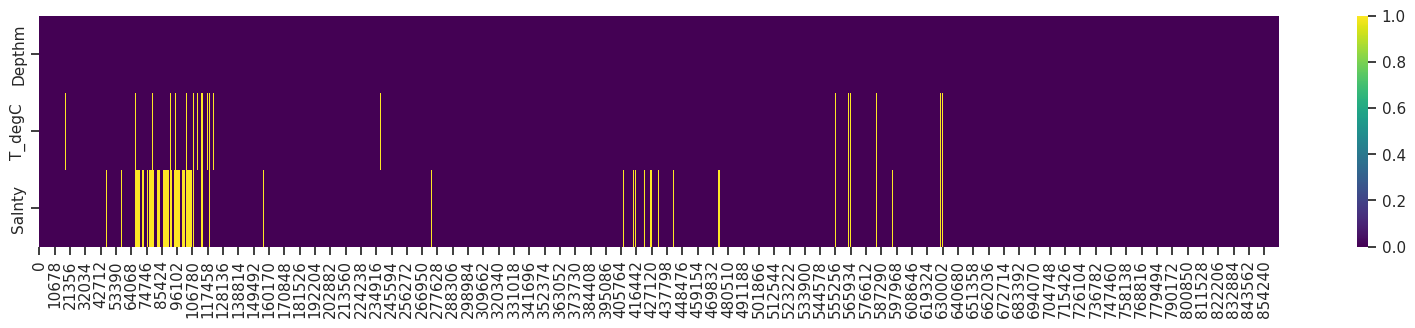

In [283]:
plt.rcParams['figure.figsize'] = (20.0, 3) # set default size of plots
sns.heatmap(bottle.transpose().isnull(), cmap='viridis')

In [284]:
# Fill nan values with mean of previous and next values
bottle.dropna(inplace=True)
bottle.dropna(inplace=True)

<Axes: >

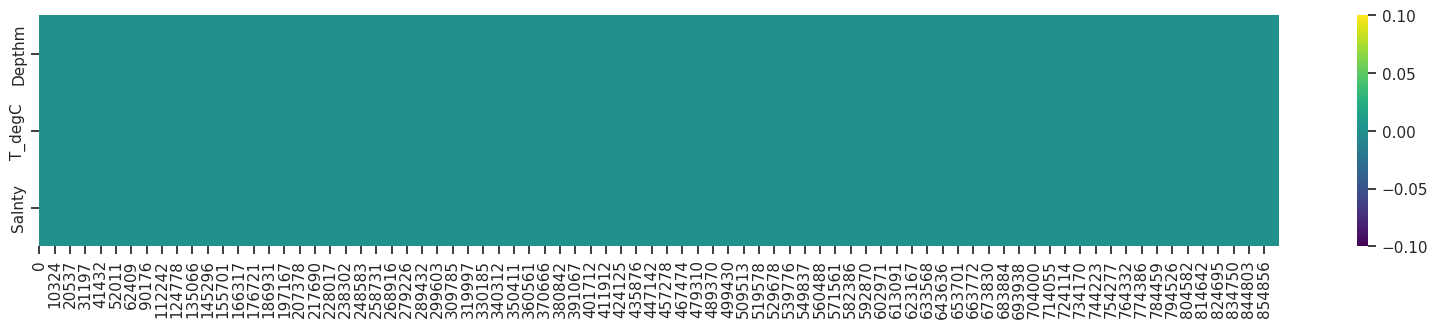

In [285]:
plt.rcParams['figure.figsize'] = (20.0, 3) # set default size of plots
sns.heatmap(bottle.transpose().isnull(), cmap='viridis')

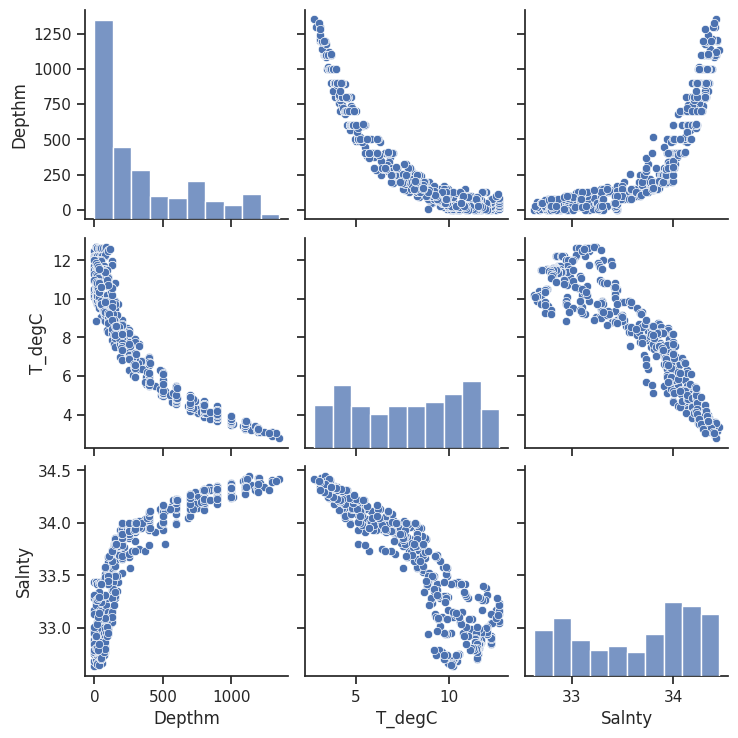

In [286]:
sns.pairplot(bottle.iloc[:500, :])

## Predict the temperature with salinity and depth informations

In [287]:
features = ['Depthm', 'Salnty']
target = 'T_degC'

In [288]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bottle[features].values, bottle[target].values, train_size=0.00065, random_state=1)

### Linear regression
Predict the temperature with salinity and depth of water

In [289]:
from sklearn.linear_model import LinearRegression
# Initialize the dictonary for error metrics
parameter_errors = dict()

i = 0

for deg in range(9):

    # crea le features polinomiali
    poly = PolynomialFeatures(degree=deg)
    x_poly = poly.fit_transform(X_train)

    # esegue la regressione lineare
    reg = LinearRegression(n_jobs=-1)
    reg.fit(x_poly, y_train)

    # Make a prediction
    X_test_poly = poly.fit_transform(X_test)
    y_pred = reg.predict(X_test_poly)

    parameter_errors[i] = {'MSE': mean_squared_error(y_test, y_pred),
                           'ME':  max_error(y_test, y_pred),
                           'MAE': mean_absolute_error(y_test, y_pred),
                           'Deg': deg}
    i += 1

    print("Polynome of degree", deg, 'done!')

Polynome of degree 0 done!
Polynome of degree 1 done!
Polynome of degree 2 done!
Polynome of degree 3 done!
Polynome of degree 4 done!
Polynome of degree 5 done!
Polynome of degree 6 done!
Polynome of degree 7 done!
Polynome of degree 8 done!


In [290]:
errors_deg = pd.DataFrame(parameter_errors).T
errors_deg.sort_values(['MAE', 'ME', 'MSE'], inplace=True)
errors_deg.head()

,MSE,ME,MAE,Deg
5,16.528097,882.703295,1.391232,5.0
4,7.668649,538.927842,1.406709,4.0
3,5.653538,409.148157,1.429894,3.0
2,4.707931,60.539113,1.626565,2.0
6,618.603273,7071.663727,1.741170,6.0


### Regressor tree

In [291]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the dictonary for error metrics
parameter_errors = dict(dict())

i = 0

for deg in range(8):
    for criterion in ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']:
        # crea le features polinomiali
        poly = PolynomialFeatures(degree=deg)
        x_poly = poly.fit_transform(X_train)

        # esegue la regressione lineare
        reg = DecisionTreeRegressor(criterion=criterion)
        reg.fit(x_poly, y_train)

        # Make a prediction
        X_test_poly = poly.fit_transform(X_test)
        y_pred = reg.predict(X_test_poly)

        index = str(deg) + ' ' + criterion

        parameter_errors[i] = {'MSE': mean_squared_error(y_test, y_pred),
                               'ME':  max_error(y_test, y_pred),
                               'MAE': mean_absolute_error(y_test, y_pred),
                               'Criterion': criterion,
                               'Deg': deg
                            }
        i += 1

    print("Polynome of degree", deg, 'done!')

Polynome of degree 0 done!
Polynome of degree 1 done!
Polynome of degree 2 done!
Polynome of degree 3 done!
Polynome of degree 4 done!
Polynome of degree 5 done!
Polynome of degree 6 done!
Polynome of degree 7 done!


In [292]:
errors_deg = pd.DataFrame(parameter_errors).T
errors_deg.sort_values(['MAE', 'ME', 'MSE'], inplace=True)
errors_deg.head(10)

,MSE,ME,MAE,Criterion,Deg
13,5.372985,14.34,1.52626,friedman_mse,3
16,5.478182,14.35,1.528731,squared_error,4
14,5.343742,14.31,1.529628,absolute_error,3
15,5.409918,14.34,1.531382,poisson,3
5,5.449447,14.34,1.532244,friedman_mse,1
17,5.503973,14.3,1.536786,friedman_mse,4
9,5.40026,14.3,1.538286,friedman_mse,2
12,5.54101,14.35,1.542853,squared_error,3
11,5.565712,14.31,1.545065,poisson,2
8,5.522851,14.35,1.546042,squared_error,2


### Regressor KNN

In [293]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize the dictonary for error metrics
parameter_errors = dict(dict())

i = 0

for deg in range(8):
    for nei in range(1, 10):
        # crea le features polinomiali
        poly = PolynomialFeatures(degree=deg)
        x_poly = poly.fit_transform(X_train)

        # esegue la regressione lineare
        reg = KNeighborsRegressor(n_neighbors=nei, n_jobs=-1)
        reg.fit(x_poly, y_train)

        # Make a prediction
        X_test_poly = poly.fit_transform(X_test)
        y_pred = reg.predict(X_test_poly)

        index = str(deg) + ' ' + str(nei)

        parameter_errors[i] = {'MSE': mean_squared_error(y_test, y_pred),
                               'ME':  max_error(y_test, y_pred),
                               'MAE': mean_absolute_error(y_test, y_pred),
                               'Neighbors': nei,
                               'Deg': deg
                            }
        i += 1

    print("Polynome of degree", deg, 'done!')

Polynome of degree 0 done!
Polynome of degree 1 done!
Polynome of degree 2 done!
Polynome of degree 3 done!
Polynome of degree 4 done!
Polynome of degree 5 done!
Polynome of degree 6 done!
Polynome of degree 7 done!


In [294]:
errors_deg = pd.DataFrame(parameter_errors).T
errors_deg.sort_values(['MAE', 'ME', 'MSE'], inplace=True)
errors_deg.head()

,MSE,ME,MAE,Neighbors,Deg
17,3.898749,15.395556,1.342586,9.0,1.0
15,3.960249,15.955714,1.343547,7.0,1.0
13,4.009706,16.580000,1.343909,5.0,1.0
16,3.937205,15.453750,1.345821,8.0,1.0
14,4.011177,16.368333,1.346921,6.0,1.0
